In [12]:
import os
import random
from collections import defaultdict
from PIL import Image
import torch
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import struct
from tqdm import trange
# 设置随机种子以确保结果可重现
random.seed(42)

# 配置数据保存路径
output_dir = '/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist/images'
os.makedirs(output_dir, exist_ok=True)

# 加载MNIST数据集
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 确保图像是28x28的
    transforms.ToTensor()
])

class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform

        # 加载图片和标签
        self.images = self._load_images(self.images_path)
        self.labels = self._load_labels(self.labels_path)

    def _load_images(self, path):
        with open(path, 'rb') as f:
            # Skip the first 16 bytes of the magic number and dimensions info
            f.read(16)
            # 读取所有图片数据
            data = np.frombuffer(f.read(), dtype=np.uint8)
            images = data.reshape(-1, 28, 28)  # 图片是28x28的
        return images

    def _load_labels(self, path):
        with open(path, 'rb') as f:
            # Skip the first 8 bytes of the magic number and number of labels
            f.read(8)
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = Image.fromarray(image)  # 将图片从numpy数组转为PIL图像
            image = self.transform(image)

        return image, label

# 配置转换
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 确保图像是28x28的
    transforms.ToTensor()
])

# 数据路径
train_images_path = '/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-images-idx3-ubyte'
train_labels_path = '/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-labels-idx1-ubyte'

# 加载数据
train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)


digit_images = defaultdict(list)
for img, label in train_dataset:
    digit_images[label.item()].append(img)

# 生成所有有效的三元组组合
valid_triples = []
for a in range(0, 10):
    for b in range(a, 10):
        for c in range(b, 10):
            if 15 <= (a + b + c) <= 24:
                valid_triples.append((a, b, c))

# 生成2000张合成图像
for idx in range(2000):
    while True:
        # 随机选择有效三元组并打乱顺序
        a, b, c = random.choice(valid_triples)
        nums = random.sample([a, b, c], 3)
        s = sum(nums)
        d = 24 - s

        # 确保所有数字都有可用图像
        if all(len(digit_images[n]) > 0 for n in nums + [d]):
            break

    # 随机选择图像
    img1 = random.choice(digit_images[nums[0]])
    img2 = random.choice(digit_images[nums[1]])
    img3 = random.choice(digit_images[nums[2]])
    img4 = random.choice(digit_images[d])

    # 转换并调整图像大小
    def process_img(img_tensor):
        img = to_pil_image(img_tensor).resize((32, 32), Image.LANCZOS)
        return img.convert('L')  # 确保灰度模式

    # 合成64x64图像
    canvas = Image.new('L', (64, 64), color=255)
    canvas.paste(process_img(img1), (0, 0))    # 左上
    canvas.paste(process_img(img2), (32, 0))   # 右上
    canvas.paste(process_img(img3), (0, 32))  # 左下
    canvas.paste(process_img(img4), (32, 32)) # 右下

    # 保存图像
    canvas.save(os.path.join(output_dir, f'combined_{idx:04d}.png'))

    # 打印进度
    if (idx + 1) % 100 == 0:
        print(f'已生成 {idx + 1}/2000 张图像')




已生成 100/2000 张图像
已生成 200/2000 张图像
已生成 300/2000 张图像
已生成 400/2000 张图像
已生成 500/2000 张图像
已生成 600/2000 张图像
已生成 700/2000 张图像
已生成 800/2000 张图像
已生成 900/2000 张图像
已生成 1000/2000 张图像
已生成 1100/2000 张图像
已生成 1200/2000 张图像
已生成 1300/2000 张图像
已生成 1400/2000 张图像
已生成 1500/2000 张图像
已生成 1600/2000 张图像
已生成 1700/2000 张图像
已生成 1800/2000 张图像
已生成 1900/2000 张图像
已生成 2000/2000 张图像


NameError: name 'generate_mnist_combinations' is not defined

In [14]:
import os
import torch
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn as nn
# -------------------- 设备配置 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
mnist_classes = [str(i) for i in range(10)]

Using device: cuda


In [24]:
# -------------------- MNIST模型定义 --------------------
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.features = nn.Sequential(
            # 输入: 1x28x28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 输入通道改为1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 输出: 32x14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 输出: 64x7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # 全局平均池化输出: 128x1x1
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [34]:
def generate_report(report):
    total_samples = sum(v["samples"] for v in report.values())
    total_correct = sum(int(v["accuracy"]*v["samples"]) for v in report.values())
    
    print("\n{:<30} {:<10} {:<10}".format("Folder", "Accuracy", "Samples"))
    print("-"*50)
    for folder, data in report.items():
        print(f"{folder:<30} {data['accuracy']:.2%}     {data['samples']:<10}")
    
    print("\nOverall Accuracy: {:.2%}".format(total_correct/total_samples))
    print(f"Total Samples: {total_samples}")

验证进度: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

tensor([[-53.7459,  -8.7001, -21.6833,  20.9177, -24.6376,   3.9168, -35.7238,
           6.2989, -33.0160, -13.6443]], device='cuda:0') 3
tensor([[-53.0259, -12.1218, -16.0565,  24.8588, -26.5871,   3.8469, -36.4938,
           2.8232, -28.0511, -12.2536]], device='cuda:0') 3
tensor([[-42.0783, -21.5153, -22.1611,  19.4667, -23.0932,  12.5842, -29.5226,
          -9.6360, -23.6085,  -0.5249]], device='cuda:0') 3
tensor([[-54.1972,   4.3171, -27.9862,  14.5558, -17.0534,   4.7830, -36.4898,
          -7.8024, -25.0290, -11.2526]], device='cuda:0') 3
pred_sum: 12 [3, 3, 3, 3]


验证进度: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


分析完成: 0/1 张图和为24 (占比 0.00%)


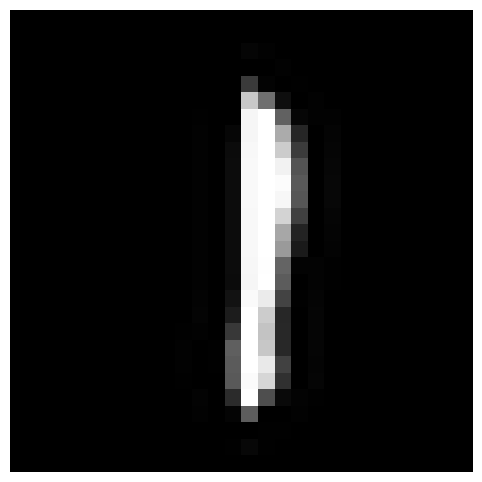

In [69]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
# -------------------- 数据集类（仅加载图像）-------------------
class ImageOnlyDataset(Dataset):
    def __init__(self, root_dir):
        """
        仅加载PNG图片，不处理任何标签
        """
        self.image_paths = []
        # 递归查找所有PNG文件
        for dirpath, _, filenames in os.walk(root_dir):
            # print(filenames)
            for filename in filenames:
                if filename.lower().endswith('1998.png'):
                    self.image_paths.append(os.path.join(dirpath, filename))
        
        if not self.image_paths:
            raise RuntimeError(f"未找到PNG图片，请检查目录: {root_dir}")

        # 图像预处理
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # MNIST标准化
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        return {
            "image": self.transform(img),  # [1, H, W]
            "path": self.image_paths[idx]
        }

# -------------------- 验证器类 --------------------
class SumValidator:
    def __init__(self, mnist_model, device):
        self.device = device
        self.model = mnist_model.to(device).eval()
        
        # 子图预处理流程（保持与MNIST一致）
        # self.subimage_transform = transforms.Compose([
        #     transforms.Resize(28),
        #     transforms.Normalize((0.1307,), (0.3081,))
        # ])
        self.subimage_transform = transforms.Compose([
            transforms.Resize(28),
            transforms.Grayscale(num_output_channels=1),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    def validate(self, dataloader):
        total = 0
        sum24_count = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="验证进度"):
                full_images = batch["image"].to(self.device)  # [B, 1, H, W]
                
                for img in full_images:
                    # 分割图像
                    sub_images = self._split_image(img)
                    
                    # 预测子图并计算和
                    pred_sum,preds = self._predict_sum(sub_images)
                    print("pred_sum:",pred_sum,preds)
                    
                    # 统计结果
                    total += 1
                    sum24_count += int(pred_sum == 24)

        accuracy = 100 * sum24_count / total if total > 0 else 0
        print(f"\n分析完成: {sum24_count}/{total} 张图和为24 (占比 {accuracy:.2f}%)")
        return accuracy

    def _split_image(self, img_tensor):
        """将图像分割为4个32x32子图"""
        _, h, w = img_tensor.shape
        if h < 64 or w < 64:
            raise ValueError(f"输入图像尺寸不足64x64，当前尺寸：{h}x{w}")
        sub_images = [
            ("Top-Left", img_tensor[:, :32, :32]),
            ("Top-Right", img_tensor[:, :32, 32:]),
            ("Bottom-Left", img_tensor[:, 32:, :32]),
            ("Bottom-Right", img_tensor[:, 32:, 32:])
        ]
        
        # 创建画布
        plt.figure(figsize=(12, 6))
        
        # -------------------- 原始图像可视化 --------------------
        # plt.subplot(2, 3, 1)  # 2行3列的第1个位置
        # 转换为numpy并反标准化
        # original_img = img_tensor.squeeze().cpu().numpy()
        # original_img = original_img * 0.3081 + 0.1307  # 反标准化
        # plt.imshow(original_img, cmap='gray')
        # plt.title("Original Image (64x64)")
        # plt.axis('off')
        
        # # -------------------- 子图可视化 --------------------
        # positions = [(0, 2), (0, 4), (1, 2), (1, 4)]  # 子图布局位置
        # for idx, (title, sub_img) in enumerate(sub_images):
        #     plt.subplot2grid((2, 5), positions[idx], colspan=2)
        #     # 转换为numpy并反标准化
        #     sub_img_np = sub_img.squeeze().cpu().numpy()
        #     sub_img_np = sub_img_np * 0.3081 + 0.1307  # 反标准化
        #     plt.imshow(sub_img_np, cmap='gray')
        #     plt.title(title)
        #     plt.axis('off')
        
        # plt.tight_layout()
    
        return [
            img_tensor[:, :32, :32],   # 左上
            img_tensor[:, :32, 32:],   # 右上
            img_tensor[:, 32:, :32],   # 左下
            img_tensor[:, 32:, 32:]    # 右下
        ]

    def _predict_sum(self, sub_images):
        """预测四个子图的数字并返回总和"""
        sum_pred = 0
        preds = []
        for i, sub_img in enumerate(sub_images):
            # 调整尺寸并添加批次维度
            sub_img = sub_img.unsqueeze(0)  # [1, 1, 32, 32]
            sub_img = torch.nn.functional.interpolate(sub_img, size=28)
            
            # 预处理
            sub_img = self.subimage_transform(sub_img)
            # 转换为NumPy并反标准化
            img_np = sub_img.squeeze().cpu().numpy()
            img_np = img_np * 0.3081 + 0.1307  # 反标准化

            # 预测
            output = self.model(sub_img)
            prob = torch.softmax(output, dim=1)
            pred = torch.argmax(prob).item()
            # pred = output.argmax(dim=1).item()
            # 显示子图
            # plt.subplot(1, 4, i+1)  # 1行4列，第i+1个位置
            plt.imshow(img_np, cmap='gray')
            # plt.title(f"Sub-image {i+1} with pre label {pred}")
            plt.savefig(f"/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist-split/Sub-image_{i+1}.png")
            plt.axis('off')
            preds.append(pred)
            sum_pred += pred
            print(output,pred)
            
        return sum_pred,preds


# -------------------- 使用示例 --------------------
if __name__ == "__main__":
    # 配置参数
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist/images"
    
    # 加载数据集
    dataset = ImageOnlyDataset(data_dir)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
    
    # 加载MNIST模型
    # mnist_model = MNIST_CNN()
    # # 修改后的模型加载代码
    # checkpoint = torch.load(
    # "/cpfs04/user/hanyujin/rule-gen/model_cpkt/mnist_cnn_best_v2.pth",
    # map_location=device
    # )
    # mnist_model.load_state_dict(checkpoint['state_dict'])  # 提取state_dict部分
    mnist_model = mnist_model
    
    # 创建验证器
    validator = SumValidator(mnist_model, device)
    
    # 执行验证
    accuracy = validator.validate(dataloader)

# Training Data 

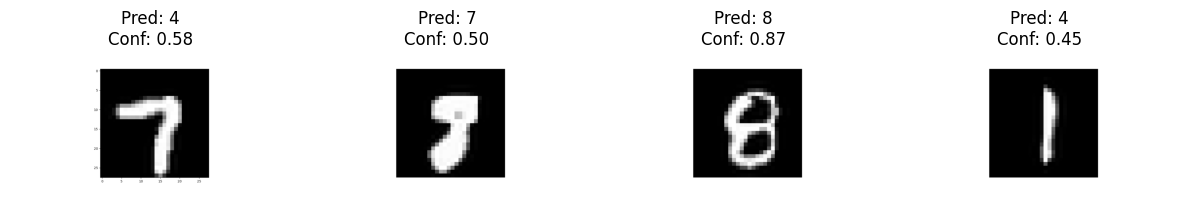

In [67]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# -------------------- 配置参数 --------------------
DATA_DIR = "/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist-split"
MODEL_PATH = "/cpfs04/user/hanyujin/rule-gen/model_cpkt/mnist_cnn_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- 数据预处理 --------------------
mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# -------------------- 预测函数 --------------------
def predict_subimages():
    # 加载模型
    model = mnist_model
    
    # 读取子图文件
    sub_images = []
    for i in range(4):
        img_path = os.path.join(DATA_DIR, f"Sub-image_{i+1}.png")
        img = Image.open(img_path).convert('L')  # 强制转换为灰度图
        sub_images.append(img)
    
    # 可视化与预测
    plt.figure(figsize=(12, 3))
    with torch.no_grad():
        for idx, img in enumerate(sub_images):
            # 预处理
            tensor_img = mnist_transform(img).unsqueeze(0).to(DEVICE)
            
            # 预测
            output = model(tensor_img)
            prob = torch.softmax(output, dim=1)
            pred = torch.argmax(prob).item()
            confidence = prob[0][pred].item()
            
            # 可视化
            plt.subplot(1, 4, idx+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Pred: {pred}\nConf: {confidence:.2f}")
            plt.axis('off')
    
    plt.tight_layout()
    # plt.savefig("/cpfs04/user/hanyujin/rule-gen/prediction_result.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    predict_subimages()

In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from tqdm import trange
# -------------------- 配置参数 --------------------
config = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 20,
    'num_workers': 4,
    'save_dir': '/cpfs04/user/hanyujin/rule-gen/model_cpkt/',
    'best_model_name': 'mnist_best_cnn_v2.pth'
}

# -------------------- 数据预处理 --------------------
train_transform = transforms.Compose([
    transforms.RandomRotation(10),        # 数据增强
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# -------------------- 数据集类 --------------------
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.transform = transform
        self.images = self._load_images(images_path)
        self.labels = self._load_labels(labels_path)

    def _load_images(self, path):
        with open(path, 'rb') as f:
            f.read(16)  # 跳过头部信息
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data.reshape(-1, 28, 28)

    def _load_labels(self, path):
        with open(path, 'rb') as f:
            f.read(8)  # 跳过头部信息
            return np.frombuffer(f.read(), dtype=np.uint8)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

# -------------------- 模型定义 --------------------
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# -------------------- 训练函数 --------------------
def train_model():
    # 创建保存目录
    os.makedirs(config['save_dir'], exist_ok=True)
    
    # 设备设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 初始化模型
    model = MNIST_CNN().to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    
    # 加载数据
    train_set = MNISTDataset(
        images_path='/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-images-idx3-ubyte',
        labels_path='/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-labels-idx1-ubyte',
        transform=train_transform
    )
    test_set = MNISTDataset(
        images_path='/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/t10k-images-idx3-ubyte',
        labels_path='/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/t10k-labels-idx1-ubyte',
        transform=test_transform
    )
    
    # 划分验证集
    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_set, [train_size, val_size]
    )
    
    # 创建DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers']
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )
    test_loader = DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    # 初始化最佳准确率
    best_acc = 0.0
    
    for epoch in trange(config['epochs']):
        # 训练阶段
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
        
        # 计算指标
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total
        
        # 学习率调整
        scheduler.step(val_acc)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 
                      os.path.join(config['save_dir'], config['best_model_name']))
        
        print(f'Epoch {epoch+1}/{config["epochs"]} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Val Acc: {val_acc:.2f}%')

    # 最终测试
    model.load_state_dict(torch.load(os.path.join(config['save_dir'], config['best_model_name'])))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    print(f'\nFinal Test Accuracy: {100 * correct / total:.2f}%')
    return model

if __name__ == "__main__":
    mnist_model = train_model()

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:04<01:27,  4.58s/it]

Epoch 1/20 | Train Loss: 0.3813 | Val Loss: 0.0858 | Val Acc: 97.80%


 10%|█         | 2/20 [00:09<01:24,  4.69s/it]

Epoch 2/20 | Train Loss: 0.0899 | Val Loss: 0.0469 | Val Acc: 98.58%


 15%|█▌        | 3/20 [00:13<01:19,  4.66s/it]

Epoch 3/20 | Train Loss: 0.0679 | Val Loss: 0.0808 | Val Acc: 97.53%


 20%|██        | 4/20 [00:18<01:13,  4.57s/it]

Epoch 4/20 | Train Loss: 0.0560 | Val Loss: 0.0364 | Val Acc: 98.98%


 25%|██▌       | 5/20 [00:22<01:08,  4.54s/it]

Epoch 5/20 | Train Loss: 0.0504 | Val Loss: 0.0312 | Val Acc: 99.17%


 30%|███       | 6/20 [00:27<01:02,  4.43s/it]

Epoch 6/20 | Train Loss: 0.0443 | Val Loss: 0.0351 | Val Acc: 98.92%


 35%|███▌      | 7/20 [00:31<00:58,  4.50s/it]

Epoch 7/20 | Train Loss: 0.0399 | Val Loss: 0.0311 | Val Acc: 99.07%


 40%|████      | 8/20 [00:36<00:54,  4.53s/it]

Epoch 8/20 | Train Loss: 0.0395 | Val Loss: 0.0424 | Val Acc: 98.62%


 45%|████▌     | 9/20 [00:41<00:50,  4.59s/it]

Epoch 9/20 | Train Loss: 0.0269 | Val Loss: 0.0243 | Val Acc: 99.23%


 50%|█████     | 10/20 [00:45<00:45,  4.58s/it]

Epoch 10/20 | Train Loss: 0.0226 | Val Loss: 0.0242 | Val Acc: 99.33%


 55%|█████▌    | 11/20 [00:50<00:41,  4.63s/it]

Epoch 11/20 | Train Loss: 0.0222 | Val Loss: 0.0240 | Val Acc: 99.35%


 60%|██████    | 12/20 [00:55<00:37,  4.63s/it]

Epoch 12/20 | Train Loss: 0.0201 | Val Loss: 0.0210 | Val Acc: 99.40%


 65%|██████▌   | 13/20 [00:59<00:32,  4.69s/it]

Epoch 13/20 | Train Loss: 0.0192 | Val Loss: 0.0232 | Val Acc: 99.32%


 70%|███████   | 14/20 [01:04<00:28,  4.67s/it]

Epoch 14/20 | Train Loss: 0.0197 | Val Loss: 0.0214 | Val Acc: 99.32%


 75%|███████▌  | 15/20 [01:08<00:22,  4.60s/it]

Epoch 15/20 | Train Loss: 0.0185 | Val Loss: 0.0247 | Val Acc: 99.28%


 80%|████████  | 16/20 [01:13<00:18,  4.61s/it]

Epoch 16/20 | Train Loss: 0.0169 | Val Loss: 0.0214 | Val Acc: 99.35%


 85%|████████▌ | 17/20 [01:18<00:13,  4.65s/it]

Epoch 17/20 | Train Loss: 0.0168 | Val Loss: 0.0211 | Val Acc: 99.38%


 90%|█████████ | 18/20 [01:22<00:09,  4.67s/it]

Epoch 18/20 | Train Loss: 0.0163 | Val Loss: 0.0199 | Val Acc: 99.50%


 95%|█████████▌| 19/20 [01:27<00:04,  4.67s/it]

Epoch 19/20 | Train Loss: 0.0156 | Val Loss: 0.0209 | Val Acc: 99.32%


100%|██████████| 20/20 [01:32<00:00,  4.60s/it]

Epoch 20/20 | Train Loss: 0.0161 | Val Loss: 0.0191 | Val Acc: 99.45%



Final Test Accuracy: 99.54%


In [71]:
import os
import random
from collections import defaultdict
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset
import numpy as np

# 设置随机种子保证可重复性
random.seed(42)
torch.manual_seed(42)

# 配置新数据保存路径
output_dir = '/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist-eo/images'
os.makedirs(output_dir, exist_ok=True)

# 数据预处理流程
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform

        # 加载图片和标签
        self.images = self._load_images(self.images_path)
        self.labels = self._load_labels(self.labels_path)

    def _load_images(self, path):
        with open(path, 'rb') as f:
            # Skip the first 16 bytes of the magic number and dimensions info
            f.read(16)
            # 读取所有图片数据
            data = np.frombuffer(f.read(), dtype=np.uint8)
            images = data.reshape(-1, 28, 28)  # 图片是28x28的
        return images

    def _load_labels(self, path):
        with open(path, 'rb') as f:
            # Skip the first 8 bytes of the magic number and number of labels
            f.read(8)
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = Image.fromarray(image)  # 将图片从numpy数组转为PIL图像
            image = self.transform(image)

        return image, label

# 配置转换
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 确保图像是28x28的
    transforms.ToTensor()
])

# 数据路径
train_images_path = '/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-images-idx3-ubyte'
train_labels_path = '/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-labels-idx1-ubyte'

# 加载数据
train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)

# 按数字类别存储图像
digit_images = defaultdict(list)
for img, label in train_dataset:
    digit_images[label.item()].append(img)

# 生成1000张符合奇偶规则的图像
for idx in range(1000):
    while True:
        # 随机选择奇偶类型
        is_even = random.choice([True, False])
        candidate_digits = [0, 2, 4, 6, 8] if is_even else [1, 3, 5, 7, 9]
        
        # 随机选择四个同奇偶数字
        digits = [random.choice(candidate_digits) for _ in range(4)]
        
        # 验证所有数字都有可用图像
        if all(len(digit_images[d]) > 10 for d in digits):  # 保证足够样本
            break

    # 选择四张不同图像
    selected_images = [
        random.choice(digit_images[digits[0]]),
        random.choice(digit_images[digits[1]]),
        random.choice(digit_images[digits[2]]),
        random.choice(digit_images[digits[3]])
    ]

    # 图像预处理函数
    def process_img(img_tensor):
        pil_img = to_pil_image(img_tensor).resize((32, 32), Image.LANCZOS)
        return pil_img.convert('L')

    # 合成64x64图像
    canvas = Image.new('L', (64, 64), color=0)  # 黑色背景
    positions = [(0, 0), (32, 0), (0, 32), (32, 32)]
    
    for img_tensor, pos in zip(selected_images, positions):
        img = process_img(img_tensor)
        canvas.paste(img, pos)

    # 保存图像并记录元数据
    filename = f"eo_{'even' if is_even else 'odd'}_{idx:04d}.png"
    canvas.save(os.path.join(output_dir, filename))

    # 进度显示
    if (idx + 1) % 100 == 0:
        print(f'已生成 {idx + 1}/1000 张图像 | 当前组合: {digits}')

print("数据集生成完成！")

已生成 100/1000 张图像 | 当前组合: [0, 6, 6, 8]
已生成 200/1000 张图像 | 当前组合: [9, 1, 1, 1]
已生成 300/1000 张图像 | 当前组合: [4, 2, 6, 8]
已生成 400/1000 张图像 | 当前组合: [6, 2, 2, 4]
已生成 500/1000 张图像 | 当前组合: [3, 1, 7, 5]
已生成 600/1000 张图像 | 当前组合: [3, 7, 1, 9]
已生成 700/1000 张图像 | 当前组合: [7, 7, 5, 5]
已生成 800/1000 张图像 | 当前组合: [0, 0, 6, 8]
已生成 900/1000 张图像 | 当前组合: [1, 5, 3, 1]
已生成 1000/1000 张图像 | 当前组合: [8, 8, 4, 2]
数据集生成完成！


In [2]:
import os
import random
from collections import defaultdict
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset
import numpy as np

# 设置随机种子保证可重复性
random.seed(42)
torch.manual_seed(42)

# 配置新数据保存路径
output_dir = '/cpfs04/user/hanyujin/rule-gen/datasets/mnist-mnist-seq/images'
os.makedirs(output_dir, exist_ok=True)

# 数据预处理流程
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])


class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform

        # 加载图片和标签
        self.images = self._load_images(self.images_path)
        self.labels = self._load_labels(self.labels_path)

    def _load_images(self, path):
        with open(path, 'rb') as f:
            # Skip the first 16 bytes of the magic number and dimensions info
            f.read(16)
            # 读取所有图片数据
            data = np.frombuffer(f.read(), dtype=np.uint8)
            images = data.reshape(-1, 28, 28)  # 图片是28x28的
        return images

    def _load_labels(self, path):
        with open(path, 'rb') as f:
            # Skip the first 8 bytes of the magic number and number of labels
            f.read(8)
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = Image.fromarray(image)  # 将图片从numpy数组转为PIL图像
            image = self.transform(image)

        return image, label

# 配置转换
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 确保图像是28x28的
    transforms.ToTensor()
])

# 数据路径
train_images_path = '/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-images-idx3-ubyte'
train_labels_path = '/cpfs04/user/hanyujin/rule-gen/datasets/MNIST/raw/train-labels-idx1-ubyte'

# 加载数据
train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)


# 按数字类别存储图像
digit_images = defaultdict(list)
for img, label in train_dataset:
    digit_images[label.item()].append(img)

# 生成1000张等差序列图像
valid_sequences = []
for start in range(7):  # 允许的起始数字范围(0-6)
    seq = [start, start+1, start+2, start+3]
    if all(d in digit_images and len(digit_images[d]) > 10 for d in seq):
        valid_sequences.append(seq)

total_generated = 0
while total_generated < 1000:
    # 随机选择有效序列
    sequence = random.choice(valid_sequences)
    
    try:
        # 选择四张不同图像
        selected_images = [
            random.choice(digit_images[sequence[0]]),
            random.choice(digit_images[sequence[1]]),
            random.choice(digit_images[sequence[2]]),
            random.choice(digit_images[sequence[3]])
        ]
    except IndexError:
        continue

    # 图像预处理函数
    def process_img(img_tensor):
        pil_img = to_pil_image(img_tensor).resize((32, 32), Image.LANCZOS)
        return pil_img.convert('L')

    # 合成64x64图像
    canvas = Image.new('L', (64, 64), color=0)  # 黑色背景
    positions = [(0, 0), (32, 0), (0, 32), (32, 32)]
    
    for img_tensor, pos in zip(selected_images, positions):
        img = process_img(img_tensor)
        canvas.paste(img, pos)

    # 保存图像并记录元数据
    filename = f"seq_{sequence[0]}-{sequence[3]}_{total_generated:04d}.png"
    canvas.save(os.path.join(output_dir, filename))
    
    total_generated += 1

    # 进度显示
    if total_generated % 100 == 0:
        print(f'已生成 {total_generated}/1000 张图像 | 当前序列: {sequence}')

print("等差序列数据集生成完成！")

已生成 100/1000 张图像 | 当前序列: [1, 2, 3, 4]
已生成 200/1000 张图像 | 当前序列: [3, 4, 5, 6]
已生成 300/1000 张图像 | 当前序列: [3, 4, 5, 6]
已生成 400/1000 张图像 | 当前序列: [1, 2, 3, 4]
已生成 500/1000 张图像 | 当前序列: [6, 7, 8, 9]
已生成 600/1000 张图像 | 当前序列: [0, 1, 2, 3]
已生成 700/1000 张图像 | 当前序列: [6, 7, 8, 9]
已生成 800/1000 张图像 | 当前序列: [1, 2, 3, 4]
已生成 900/1000 张图像 | 当前序列: [1, 2, 3, 4]
已生成 1000/1000 张图像 | 当前序列: [2, 3, 4, 5]
等差序列数据集生成完成！
